In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import folium
import json
import geopandas as gpd

In [4]:
# define path
path = r'C:\Users\Administrator\Documents\data analytics\Advanced Analytics and Dashbord Design\World Happiness 2016-2024\02 Data'

In [5]:
# Prompt matplotlib visuals to appear in the notebook 

%matplotlib inline

In [6]:
# import df world happiness report 2024. I call it whr to have a short name.
whr = pd.read_pickle(os.path.join(path,'whr1.pkl'))

In [7]:
# import .json file to have the geospatial dimension
geo = pd.read_json(os.path.join(path,'world-countries.json'))

In [8]:
# Look at .json columns. I looked in the file and it included countries.

print(geo.columns)

Index(['type', 'features'], dtype='object')


In [9]:
whr.head(3)

,Generosity,Year,Overall rank,Country or region,Freedom to make life choices,Life expectancy,Happiness (Score),Trust (Gov.corruption),Economy (GDP p. cap.),Family support
0,0.29678,2015,1.0,Switzerland,0.66557,0.94143,7.587,0.41978,1.39651,1.34951
1,0.43630,2015,2.0,Iceland,0.62877,0.94784,7.561,0.14145,1.30232,1.40223
2,0.34139,2015,3.0,Denmark,0.64938,0.87464,7.527,0.48357,1.32548,1.36058


In [10]:
whr.shape

(782, 10)

In [11]:
# DATA WRANGLING (IF NEEDED)

In [12]:
# List values in the country or region column
values_list = whr['Country or region'].tolist()
print(values_list)

['Switzerland', 'Iceland', 'Denmark', 'Norway', 'Canada', 'Finland', 'Netherlands', 'Sweden', 'New Zealand', 'Australia', 'Israel', 'Costa Rica', 'Austria', 'Mexico', 'United States', 'Brazil', 'Luxembourg', 'Ireland', 'Belgium', 'United Arab Emirates', 'United Kingdom', 'Oman', 'Venezuela', 'Singapore', 'Panama', 'Germany', 'Chile', 'Qatar', 'France', 'Argentina', 'Czech Republic', 'Uruguay', 'Colombia', 'Thailand', 'Saudi Arabia', 'Spain', 'Malta', 'Taiwan', 'Kuwait', 'Suriname', 'Trinidad and Tobago', 'El Salvador', 'Guatemala', 'Uzbekistan', 'Slovakia', 'Japan', 'South Korea', 'Ecuador', 'Bahrain', 'Italy', 'Bolivia', 'Moldova', 'Paraguay', 'Kazakhstan', 'Slovenia', 'Lithuania', 'Nicaragua', 'Peru', 'Belarus', 'Poland', 'Malaysia', 'Croatia', 'Libya', 'Russia', 'Jamaica', 'North Cyprus', 'Cyprus', 'Algeria', 'Kosovo', 'Turkmenistan', 'Mauritius', 'Hong Kong', 'Estonia', 'Indonesia', 'Vietnam', 'Turkey', 'Kyrgyzstan', 'Nigeria', 'Bhutan', 'Azerbaijan', 'Pakistan', 'Jordan', 'Montene

In [13]:
# Data cleaning: Get rid of the missing values nan in the Country and region column since this will not show anything in the chloropleth map.

whr_clean = whr.dropna(subset=['Country or region'])

In [14]:
values_list = whr_clean['Country or region'].tolist()
print(values_list)

['Switzerland', 'Iceland', 'Denmark', 'Norway', 'Canada', 'Finland', 'Netherlands', 'Sweden', 'New Zealand', 'Australia', 'Israel', 'Costa Rica', 'Austria', 'Mexico', 'United States', 'Brazil', 'Luxembourg', 'Ireland', 'Belgium', 'United Arab Emirates', 'United Kingdom', 'Oman', 'Venezuela', 'Singapore', 'Panama', 'Germany', 'Chile', 'Qatar', 'France', 'Argentina', 'Czech Republic', 'Uruguay', 'Colombia', 'Thailand', 'Saudi Arabia', 'Spain', 'Malta', 'Taiwan', 'Kuwait', 'Suriname', 'Trinidad and Tobago', 'El Salvador', 'Guatemala', 'Uzbekistan', 'Slovakia', 'Japan', 'South Korea', 'Ecuador', 'Bahrain', 'Italy', 'Bolivia', 'Moldova', 'Paraguay', 'Kazakhstan', 'Slovenia', 'Lithuania', 'Nicaragua', 'Peru', 'Belarus', 'Poland', 'Malaysia', 'Croatia', 'Libya', 'Russia', 'Jamaica', 'North Cyprus', 'Cyprus', 'Algeria', 'Kosovo', 'Turkmenistan', 'Mauritius', 'Hong Kong', 'Estonia', 'Indonesia', 'Vietnam', 'Turkey', 'Kyrgyzstan', 'Nigeria', 'Bhutan', 'Azerbaijan', 'Pakistan', 'Jordan', 'Montene

In [15]:
# nan values per column
nan_count = whr_clean.isna().sum()
print(nan_count)

Generosity                      0
Year                            0
Overall rank                    0
Country or region               0
Freedom to make life choices    0
Life expectancy                 0
Happiness (Score)               0
Trust (Gov.corruption)          0
Economy (GDP p. cap.)           0
Family support                  0
dtype: int64


In [16]:
# Check for extreme values
# Summary statistics
print(whr_clean.describe())

# Identify potential outliers using IQR (Interquartile Range)
numeric_cols = whr_clean.select_dtypes(include='number').columns

for col in numeric_cols:
    Q1 = whr_clean[col].quantile(0.25)
    Q3 = whr_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = whr_clean[(whr_clean[col] < Q1 - 1.5 * IQR) | (whr_clean[col] > Q3 + 1.5 * IQR)]
    print(f"{col} - Number of outliers: {len(outliers)}")

       Generosity         Year  Overall rank  Freedom to make life choices  \
count  470.000000   470.000000    470.000000                    470.000000   
mean     0.242241  2015.993617     78.829787                      0.402828   
std      0.131543     0.816907     45.281408                      0.150356   
min      0.000000  2015.000000      1.000000                      0.000000   
25%      0.152831  2015.000000     40.000000                      0.297615   
50%      0.223140  2016.000000     79.000000                      0.418347   
75%      0.315824  2017.000000    118.000000                      0.516850   
max      0.838075  2017.000000    158.000000                      0.669730   

       Life expectancy  Happiness (Score)  Trust (Gov.corruption)  \
count       470.000000         470.000000              470.000000   
mean          0.579968           5.370728                0.134790   
std           0.240161           1.136998                0.111313   
min           0.00000

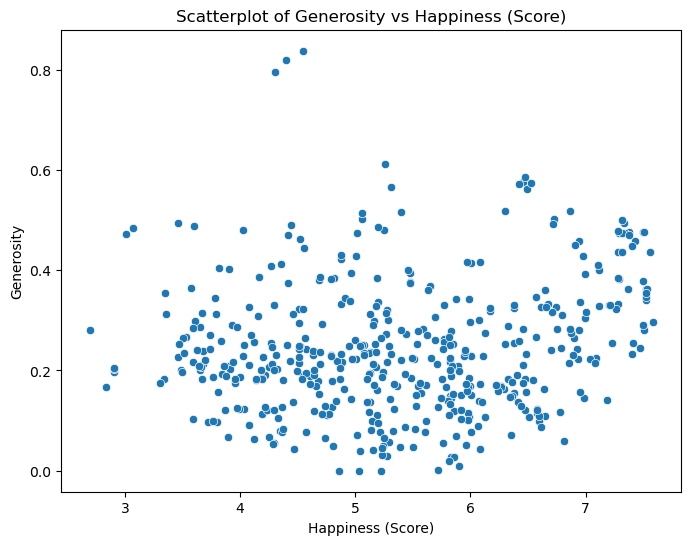

In [17]:
# Choose the columns for x and y axes
x_col = 'Happiness (Score)'    # Independent variable
y_col = 'Generosity'           # Dependent variable

# Plot scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=whr_clean[x_col], y=whr_clean[y_col])
plt.title(f'Scatterplot of {y_col} vs {x_col}')
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.show()


In [18]:
# Keep columns only in the normal data range
numeric_cols = whr_clean.select_dtypes(include='number').columns

whr_filtered = whr_clean.copy()
for col in numeric_cols:
    Q1 = whr_filtered[col].quantile(0.25)
    Q3 = whr_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    whr_filtered = whr_filtered[(whr_filtered[col] >= lower_bound) & (whr_filtered[col] <= upper_bound)]

print(f"Original rows: {len(whr_clean)}, Filtered rows: {len(whr_filtered)}")

Original rows: 470, Filtered rows: 420


In [19]:
whr_filtered.shape

(420, 10)

In [20]:
!pip install geopandas

In [22]:
import os
print(os.getcwd())

C:\Users\Administrator\Documents\data analytics\Advanced Analytics and Dashbord Design\World Happiness 2016-2024\03 Scripts


In [23]:
# define path since it is looking in the wrong folder for the geo file
path = r'C:\Users\Administrator\Documents\data analytics\Advanced Analytics and Dashbord Design\World Happiness 2016-2024\02 Data'

In [65]:
# Read the .json file.
gdf = gpd.read_file(r'C:\Users\Administrator\Documents\data analytics\Advanced Analytics and Dashbord Design\World Happiness 2016-2024\02 Data\world-countries.json')
# Drop missing entries in it.
gdf = gdf.dropna(subset=["geometry"])

In [66]:
# Show first row’s properties
print(gdf.columns)
print(gdf.head(1))

Index(['id', 'name', 'geometry'], dtype='object')
    id         name                                           geometry
0  AFG  Afghanistan  POLYGON ((61.21082 35.65007, 62.23065 35.27066...


In [67]:
key_on="feature.properties.name"

In [68]:
print(gdf.columns)

Index(['id', 'name', 'geometry'], dtype='object')


In [69]:
# Create cloropleth map
import folium

# Create base map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add choropleth
choropleth = folium.Choropleth(
    geo_data=gdf,
    data=whr_filtered,
    columns=["Country or region", "Happiness (Score)"],
    key_on="feature.properties.name",
    fill_color="Greens",
    fill_opacity=0.7,
    line_opacity=1,           # show Choropleth borders
    line_color="black",       # black borders
    legend_name="Happiness Score 2015-2019"
).add_to(m)

# Save map
m.save("choropleth_map.html")
print("Map created and saved as choropleth_map.html")

Map created and saved as choropleth_map.html


In [74]:
# Get all country names from the GeoJSON
geo_names = gdf['name'].tolist()

# Get all country names from your dataset
data_names = whr_filtered['Country or region'].tolist()

# Find countries in your data that don't match the GeoJSON
missing = [c for c in data_names if c not in geo_names]

print("Countries missing in GeoJSON:", missing)

Countries missing in GeoJSON: ['Malta', 'Bahrain', 'Mauritius', 'Palestine', 'Comoros', 'Bahrain', 'Mauritius', 'Hong Kong S.A.R., China', 'Palestine', 'Comoros', 'Bahrain', 'Mauritius', 'Hong Kong S.A.R., China', 'Palestine']


In [77]:
# --- Step 1: Define mapping to match GeoJSON country names ---
name_mapping = {
    "United States": "United States of America",
    "Malta": "Malta",
    "Bahrain": "Bahrain",
    "North Cyprus": "Northern Cyprus",  # adjust if GeoJSON name differs
    "Mauritius": "Mauritius",
    "Serbia": "Republic of Serbia",
    "Palestinian Territories": "Palestine",
    "Congo (Kinshasa)": "Democratic Republic of the Congo",
    "Congo (Brazzaville)": "Republic of the Congo",
    "Comoros": "Comoros",
    "Tanzania": "United Republic of Tanzania",
    "Hong Kong": "Hong Kong S.A.R., China",
    "Taiwan Province of China": "Taiwan"
}

# --- Step 2: Apply mapping to your dataset ---
whr_filtered['Country or region'] = whr_filtered['Country or region'].replace(name_mapping)

# --- Step 3: Create base map ---
m = folium.Map(location=[20, 0], zoom_start=2)

# --- Step 4: Add Choropleth ---
choropleth = folium.Choropleth(
    geo_data=gdf,
    data=whr_filtered,
    columns=["Country or region", "Happiness (Score)"],
    key_on="feature.properties.name",
    fill_color="Greens",
    fill_opacity=0.7,
    line_opacity=1,
    line_color="black",
    legend_name="Happiness Score 2015-2019"
).add_to(m)

# --- Optional: Add hover tooltips ---
folium.GeoJson(
    gdf,
    name="Countries",
    style_function=lambda feature: {
        "fillColor": "transparent",
        "color": "black",
        "weight": 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["name"],
        aliases=["Country:"],
        localize=True
    )
).add_to(m)

# --- Step 5: Save map as HTML ---
m.save("choropleth_map.html")
print("Map created and saved as choropleth_map.html")

Map created and saved as choropleth_map.html


In [80]:
# Discussion:
# Previously defined hypothesis:
# Higher scores in GDP per capita, life expectancy, freedom to make life choices, Happiness, Trust, and Family support all lead to a lower overall ranking (=better result). 
# Additions to hypothesis after creating the cloropleth map:
# Some “unexpected” countries receive a very good result in the World Happiness report when measuring the Happiness Score. What factors influence more than others on the overall ranking? (Follow up questions: Is there a limit to the happiness also in Western countries? Do we believe that we are happier only dependent on economic wellbeing?)
# Is there a possibility that bias occur? How is the data collected and how are the respondents selected? If a statal organization is involved maybe they select based on incorrect criteria, especially if they have a high level of corruption.
# Thailand and Myanmar rank pretty high. This is also a surprise. Are there any common factors between these two countries? Are there differences between Asian, African, North American and Western European countries? Beliefs? Religion?
